In [1]:
import pandas as pd
import numpy as np 
import os
from src import *
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
annotations_path = 'data/annotation/'

In [3]:
test_names = get_all_file_names('data/train_1')

In [4]:
file = "1385689774_1.jpg"

In [5]:
a = np.load("np_data/run_input_training_data.npy", allow_pickle=True)

In [6]:
I          = np.array(cv2.imread("data/train_1/" +file, cv2.IMREAD_GRAYSCALE), dtype=np.int32)
h, w       = I.shape
h_pad      = (int((h / 100) * 20))
w_pad      = (int((w / 100) * 20))
I          = cv2.copyMakeBorder(I, h_pad, h_pad, w_pad, w_pad, cv2.BORDER_CONSTANT)
bb         = get_rectangle_bounding_box_for_image("data/train_1/"+file, frontalface_config='default')

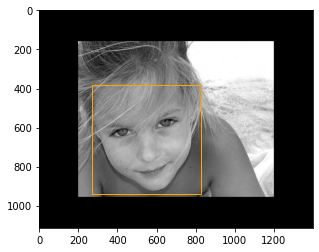

In [7]:
bb_center_x = bb[0] + w_pad
bb_center_y = bb[1] + h_pad
bb_w        = bb[2]
bb_h        = bb[3]



fig, ax = plt.subplots()
ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.imshow(I,cmap='gray')


In [8]:
annotation_files = get_all_file_names(annotations_path)

image_to_annotation_dict = {}
for file in annotation_files:
    with open(annotations_path+file) as f:
        first_line = f.readline().replace('\n','')
    image_to_annotation_dict[first_line] = file

In [9]:
S_0 = a[0][1]#get_mean_shape_from_files(test_names, image_to_annotation_dict,annotations_path)
#S_0 = center_shape(S_0)
features_0 = a[0][4] #np.load("np_data/mean_shape_features.npy", allow_pickle=True)


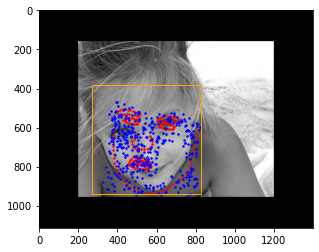

In [10]:
fig, ax = plt.subplots()
ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(a[0][1][:,0],a[0][1][:,1],c='r',s=2)
ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(I,cmap='gray')

In [11]:
#NOTE scalling to bb; We choose to multiply s hat height by some constant to make up for the extra padding the bounding box adds
#S_0_height      = np.max(S_0[:,1]) - np.min(S_0[:,1])
#scale_value            = bb_h / (S_0_height *1.3)
#S_0             = S_0 *scale_value
#features_0    = features_0 *scale_value

In [12]:
#S_0 += [bb_center_x+bb_w/2,bb_center_y+bb_h/2]
#features_0 += [bb_center_x+bb_w/2,bb_center_y+bb_h/2]
#features_0 = features_0.astype(int)

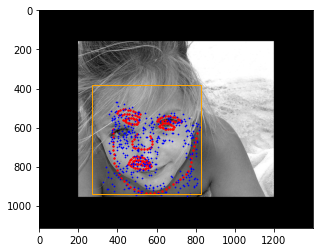

In [13]:
fig, ax = plt.subplots()
ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(S_0[:,0],S_0[:,1],c='r',s=2)
ax.scatter(features_0[:,0],features_0[:,1],c='b',s=0.5)
ax.imshow(I,cmap='gray')

In [14]:
intensities = I[np.array(features_0[:,1]), np.array(features_0[:,0])]

In [15]:
#intensities = intensities*0

# Running through one cascade 

In [16]:
cascade0 = np.load("run_output/run_output_model_regression_trees_cascade_0.npy", allow_pickle=True)

In [17]:
tree = cascade0[0]

In [18]:
"""count = 0
for node in tree._nodes:
    
    if isinstance(node, Leaf):
        print(node.avarage_residual_vector)
        count +=1 """


'count = 0\nfor node in tree._nodes:\n    \n    if isinstance(node, Leaf):\n        print(node.avarage_residual_vector)\n        count +=1 '

In [19]:
forrest_contribution = np.zeros((388,))

In [20]:
for tree in cascade0:
    forrest_contribution = forrest_contribution + 0.1* get_avarage_residual_vector_for_image(tree, intensities )

In [21]:
x_mask = [x for x in range(0, len(forrest_contribution)-1, 2)]
y_mask = [x for x in range(1, len(forrest_contribution), 2)]

In [22]:
S_1 = S_0 + list(zip(forrest_contribution[x_mask], forrest_contribution[y_mask]))

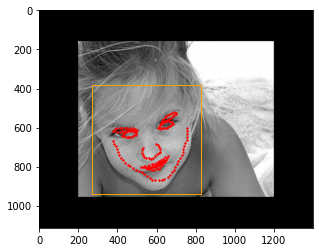

In [23]:
fig, ax = plt.subplots()

ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(S_1[:,0],S_1[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=0.5)
ax.imshow(I,cmap='gray')

# Running through many cascades 

In [24]:
#Calculate means of mean_shape for moving it and its features to origo
S_0_mean       = np.mean(S_0, axis=0)
S_0_centered   = S_0 - S_0_mean
features_0_centered = features_0 - S_0_mean

In [25]:
#Calculate means of s_hat_new for moving it and its features to origo
S_1_mean = np.mean(S_1, axis=0)
S_1_centered = S_1 - S_1_mean

features_1 = transform_features(S_0_centered, S_1_centered, features_0_centered).astype(int)

#Move features_hat_new back to image's coordinate system
features_1 += S_1_mean.astype(int)

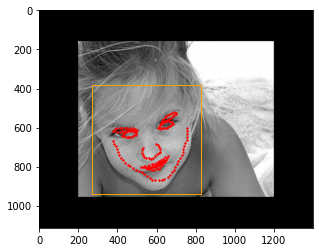

In [26]:
fig, ax = plt.subplots()

ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(S_1[:,0],S_1[:,1],c='r',s=2)
#ax.scatter(features_1[:,0],features_1[:,1],c='b',s=0.5)
ax.imshow(I,cmap='gray')

In [27]:
def apply_cascade(S_0, features_0, I, cascade):
    forrest_contribution = np.zeros((388,))
    
    x_mask = [x for x in range(0, len(forrest_contribution)-1, 2)]
    y_mask = [x for x in range(1, len(forrest_contribution), 2)]
    
    intensities = I[np.array(features_0[:,1]), np.array(features_0[:,0])]
    
    for tree in cascade0:
        forrest_contribution = forrest_contribution + 0.1* get_avarage_residual_vector_for_image(tree, intensities )
    
    S_1 = S_0 + list(zip(forrest_contribution[x_mask], forrest_contribution[y_mask]))
    
    #Calculate means of mean_shape for moving it and its features to origo
    S_0_mean       = np.mean(S_0, axis=0)
    S_0_centered   = S_0 - S_0_mean
    features_0_centered = features_0 - S_0_mean
    
    #Calculate means of s_hat_new for moving it and its features to origo
    S_1_mean = np.mean(S_1, axis=0)
    S_1_centered = S_1 - S_1_mean

    features_1 = transform_features(S_0_centered, S_1_centered, features_0_centered).astype(int)

    #Move features_hat_new back to image's coordinate system
    features_1 += S_1_mean.astype(int)
    
    return features_1, S_1 

In [28]:
f1, s1 = apply_cascade(S_0, features_0, I, cascade0)

In [29]:
f1 = features_0
s1 = S_0

for cascade in range(10):
    cascade = np.load("run_output/run_output_model_regression_trees_cascade_"+str(cascade)+".npy", allow_pickle=True)
    f1, s1 = apply_cascade(s1, f1, I, cascade)
    
fig, ax = plt.subplots()

ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s1[:,0],s1[:,1],c='r',s=2)
#ax.scatter(f1[:,0],f1[:,1],c='b',s=0.5)
ax.imshow(I,cmap='gray')

IndexError: index 1120 is out of bounds for axis 0 with size 1114